# 12.4 실습: 데이터 나누기
## 데이터 준비
학습 : 검증 : 테스트

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target

scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, :-1] = scaler.transform(df.values[:, :-1])

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data = torch.from_numpy(df.values).float()
x = data[:, :-1]
y = data[:, -1:]
print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [3]:
# 여기서는 분할 비율만 설정
# 실제 데이터 분할은 렌덤하게 섞은 다음에 split() 함수로 나눔
ratio = [.6, .2, .2]

train_cnt = int(data.size(0) * ratio[0])
valid_cnt = int(data.size(0) * ratio[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 12384 / Valid 4128 / Test 4128 samples.


## 데이터 랜덤화와 분할

In [5]:
indices = torch.randperm(data.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([12384, 8]) torch.Size([12384, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])
torch.Size([4128, 8]) torch.Size([4128, 1])


## 데이터 정규화
- 정규화를 나중에 하는 이유는? 학습에 검증, 테스트 데이터의 영향을 줄이고 학습 데이터만으로 정규화를 하기 위해
- 학습 데이터만으로 정규화(fit) 진행
- 검증, 데스트 데이터 제외
- 학습 데이터로만 정규화한 변환 비율로 학습, 검증, 테스트 데이터로 변환

In [6]:
scaler = StandardScaler()
scaler.fit(x[0].numpy())

x[0] = torch.from_numpy(scaler.transform(x[0].numpy())).float()
x[1] = torch.from_numpy(scaler.transform(x[1].numpy())).float()
x[2] = torch.from_numpy(scaler.transform(x[2].numpy())).float()

## 하이퍼파라미터 설정
- 조기 종료 설정: 일정 애폭 동안 성능 개선이 없으면 종료하도록 설정

In [9]:
n_epochs = 4000
batch_size = 256
print_interval = 100
early_stop = 100 
# early_stop만큼의 기간동안 성능 개선이 없으면(loss가 커지면) 종료 
# early_stop이 0이면 n_epochs만큼 끝까지 학습

In [12]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
)

optimizer = optim.Adam(model.parameters())

## 학습

In [13]:
import numpy as np
from copy import deepcopy

lowest_loss = np.inf
best_model = None

lowest_epoch = np.inf

In [51]:
import time
start = time.time()

train_history, valid_history = [], []

for i in range(n_epochs):
    # shuffle
    indices = torch.randperm(x[0].size(0))
    
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0

    # 학습 과정
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)

    # 1 epoch당 평균 손실값(학습)
    train_loss /= len(x_)
    
    # 검증 과정
    with torch.no_grad(): # 개선 그래프 생성을 하지 않음
        # shuffle 과정 필요 없음
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_): # iteration: 4,128 // 256 + 1 = 17
            y_hat_i = model(x_i)
            loss = F.mse_loss(y_hat_i, y_i)

            valid_loss += float(loss)

    # 1 epoch당 평균 손실값(검증)
    valid_loss /= len(x_)

    # 손실값을 그리기 위한 손실값 저장
    train_history += [train_loss] # epoch마다 학습 손실값 차례로 저장
    valid_history += [valid_loss] # epoch마다 검증 손실값 차례로 저장

    # 출력
    if (i+1) % print_interval == 0:
        print('Epoch %d/%d: train_loss=%.4f valid_loss=%.4f lowest_loss=%.4f elapsed_time=%.2fsec'%(
              (i+1), n_epochs, 
              train_loss,
              valid_loss,
              lowest_loss,
              time.time() - start
             ))
        start = time.time()

    # 검증 손실의 최소값 찾기
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict()) # 최소 손실일 때 모델을 저장

    else: 
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print('There is no improvement during last %d epochs.' %early_stop)
            break

# 학습 종료 후
print('The best validation loss from epoch %d: %.4f' %(lowest_epoch+1, lowest_loss))

model.load_state_dict(best_model) # 최소 손실의 모델로 회귀

Epoch 100/4000: train_loss=0.3354 valid_loss=0.3450 lowest_loss=0.3444 elapsed_time=2.13sec
There is no improvement during last 100 epochs.
The best validation loss from epoch 2: 0.3444


<All keys matched successfully>

## 손실 곡선 확인

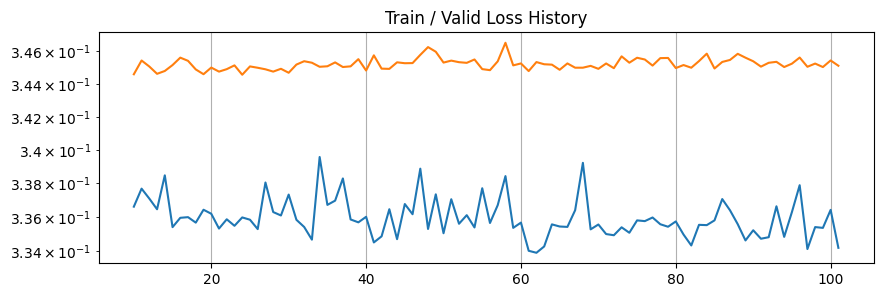

In [52]:
plot_from = 10

plt.figure(figsize=(10,3))
plt.grid(True)
plt.title("Train / Valid Loss History")

plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='Train loss')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid loss')
plt.yscale('log')
plt.show()

In [53]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        test_loss += loss  # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print("Train loss: %.4f" % sorted_history[0][0])
print("Valid loss: %.4f" % sorted_history[0][1])
print("Test loss: %.4f" % test_loss)

Train loss: 0.3360
Valid loss: 0.3445
Test loss: 0.3279


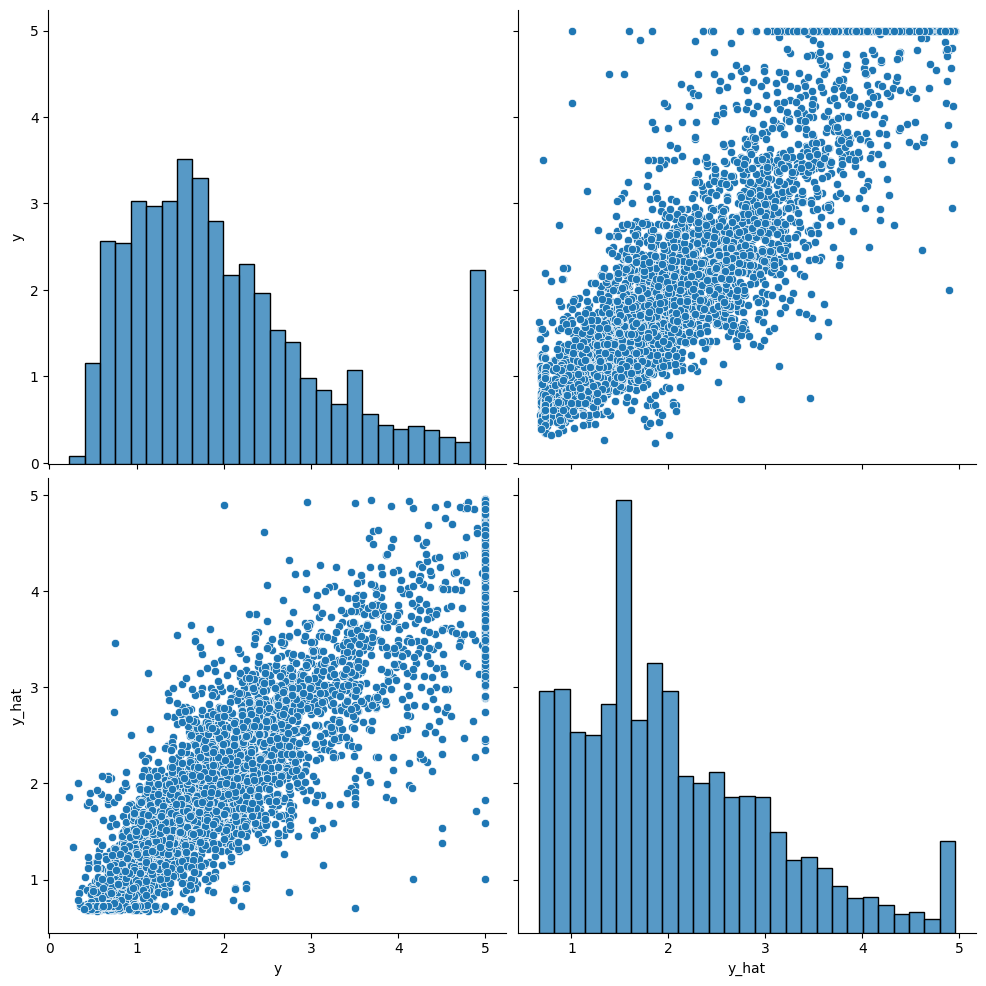

In [54]:
df = pd.DataFrame(torch.cat([y[2], y_hat], dim=1).detach().numpy(),
                  columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()

# 13.1 이진 분류
## 심층신경망을 활용한 이진 분류
- 로지스틱 회귀에서 사용한 신경망 대신 심층신경망으로 교체
- BCE 손실함수의 미분은 체인롤을 통해 각 계층을 거슬러 역전파됨
- 결과(출력층)가 여러가지일 수 있음

# 13.2 평가 지표
## 이진 분류 문제
- 기본: 시그모이드 함수의 결과(0~1)를 0.5를 기준으로 이진 분류함
- 필요에 따라서는 임계값을 참, 거짓의 분포를 보고 사람이 값을 결정하기도 함 → 하이퍼파라미터
- 임계값을 설정하기 위한 정책 → 풀고자 하는 문제의 성격에 따름
    - 원자력 발전소의 방사능 누출 감지 여부
    - 전재산을 주식에 투자할 때의 투자 정책
    - 유방암 진단

- 혼동행렬
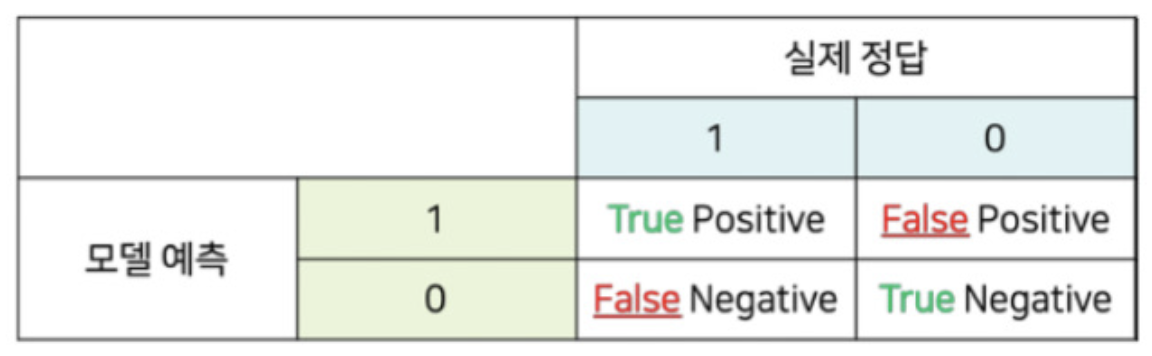

## 정확도 (accuracy)
- 맞춘 것(True)에 대한 비율
- 가장 널리 쓰이는 지표로 클래스별 성능의 자세한 분석 어려움
- 데이트 데이터셋의 클래스가 불균형할 경우 모델 성능 부정확